## Imports

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb


In [158]:
df = pd.read_csv('train.csv')
df.dropna(subset=['value_eur'], inplace=True)
df = df[~df["player_positions"].str.contains("GK", na=False)]

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13610 entries, 0 to 15390
Data columns (total 76 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   13610 non-null  int64  
 1   id                           13610 non-null  int64  
 2   short_name                   13610 non-null  object 
 3   long_name                    13610 non-null  object 
 4   player_positions             13610 non-null  object 
 5   overall                      13610 non-null  int64  
 6   potential                    13610 non-null  int64  
 7   value_eur                    13610 non-null  float64
 8   wage_eur                     13610 non-null  float64
 9   age                          13610 non-null  int64  
 10  dob                          13610 non-null  object 
 11  height_cm                    13610 non-null  int64  
 12  weight_kg                    13610 non-null  int64  
 13  club_team_id         

## Drop irrelevant columns

In [160]:
cols_to_drop = ['Unnamed: 0', 'id', 'short_name', "long_name", "dob", "club_jersey_number", "nation_jersey_number", "club_id", "club_loaned_from", "nation_position", "player_traits", "player_tags", "nationality_name", "club_team_id", "nationality_id"]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

## Contract-related variable manipulation

In [161]:
start_date = float(2021) # year when dataset was recorded 
df["years_left_contract"] = df["club_contract_valid_until"] - start_date

df['club_joined'] = pd.to_datetime(df['club_joined'], format='%Y-%m-%d')
df["years_in_club"] = start_date - df["club_joined"].dt.year

In [162]:
df.drop(columns=["club_contract_valid_until", "club_joined"], inplace=True, errors='ignore')

## Work rate split

In [163]:
df[["work_attack", "work_defense"]] = df["work_rate"].str.split("/", expand=True)
maps = {"Low": 1, "Medium": 2, "High": 3}
df["work_attack"] = df["work_attack"].map(maps)
df["work_defense"] = df["work_defense"].map(maps)

## Target-based ordinal encoding for postions

In [164]:
df[["primary_position", "secondary_position", "tertiary_position"]] = df["player_positions"].str.split(",", expand=True)

In [165]:
club_position_map = df.groupby('club_position')['value_eur'].median().sort_values().rank().to_dict()
club_position_map["None"] = 0
df["club_position"] = df["club_position"].map(club_position_map)
df["primary_position"] = df["primary_position"].map(club_position_map)
df["secondary_position"] = df["secondary_position"].map(club_position_map)
df["tertiary_position"] = df["tertiary_position"].map(club_position_map)
df.drop(columns=["player_positions"], inplace=True, errors='ignore')

## Grouping Technical Attributes

In [166]:
#Attacking attributes score
df["attacking_score"] = df[[
    "attacking_crossing",
    "attacking_finishing",
    "attacking_heading_accuracy",
    "attacking_short_passing",
    "attacking_volleys"
]].mean(axis=1)

In [167]:
#Skills attributes score
df["skills_score"] = df[[
    "skill_dribbling",
    "skill_curve",
    "skill_fk_accuracy",
    "skill_long_passing",
    "skill_ball_control"
]].mean(axis=1)

In [168]:
# Movement attributes score
df["movement_score"] = df[[
    "movement_acceleration",
    "movement_sprint_speed",
    "movement_agility",
    "movement_reactions",
    "movement_balance"
]].mean(axis=1)

In [169]:
# Power attributes score
df["power_score"] = df[[
    "power_shot_power",
    "power_jumping",
    "power_stamina",
    "power_strength",
    "power_long_shots"
]].mean(axis=1)

In [170]:
# Mentality attributes score
df["mentality_score"] = df[[
    "mentality_aggression",
    "mentality_interceptions",
    "mentality_positioning",
    "mentality_vision",
    "mentality_penalties",
    "mentality_composure"
]].mean(axis=1)

In [171]:
# Defending technical attributes score
df["defending_technical_score"] = df[[
    "defending_marking_awareness",
    "defending_standing_tackle",
    "defending_sliding_tackle"
]].mean(axis=1)

## Starter bool

In [172]:
df["is_starter"] = (~df["club_position"].isin(["SUB", "RES"])).astype(int)

## Handle Missing Data

In [173]:
null_columns = df.columns[df.isnull().any()]
print(null_columns)

Index(['release_clause_eur', 'goalkeeping_speed', 'years_in_club',
       'secondary_position', 'tertiary_position'],
      dtype='object')


In [174]:
df["years_in_club"] = df['years_in_club'].fillna(df['years_in_club'].mean())
df['release_clause_eur'] = df['release_clause_eur'].fillna(0)
df['pace'] = df['pace'].fillna(0)
df['shooting'] = df['shooting'].fillna(0)
df['passing'] = df['passing'].fillna(0)
df['dribbling'] = df['dribbling'].fillna(0)
df['defending'] = df['defending'].fillna(0)
df['physic'] = df['physic'].fillna(0)
df['goalkeeping_speed'] = df['goalkeeping_speed'].fillna(0)

In [175]:
cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    df[col] = df[col].astype('category')

In [176]:
df["overall_potential"] = df["overall"] * df["potential"]

## Target based ordinal encoding for club and league

In [177]:
club_map = df.groupby('club_name', observed=True)['value_eur'].median().sort_values().rank().to_dict()
df["club_name"] = df["club_name"].map(club_map)

league_map = df.groupby('league_name', observed=True)['value_eur'].median().sort_values().rank().to_dict()
df["league_name"] = df["league_name"].map(league_map)

## Target based ordinal encoding for work_rate

In [178]:
work_rate_map = df.groupby('work_rate', observed=True)['value_eur'].median().sort_values().rank().to_dict()
df["work_rate"] = df["work_rate"].map(work_rate_map)

## Target based ordinal encoding for body_type

In [179]:
body_type_map = df.groupby('body_type', observed=True)['value_eur'].median().sort_values().rank().to_dict()
df["body_type"] = df["body_type"].map(body_type_map)

## Training

In [180]:
X = df.drop(columns=["value_eur"], errors='ignore')
y = df["value_eur"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [181]:
# Create DMatrix for training and testing
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Define parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'seed': 42
}

# Train the model
num_round = 1000
model = xgb.train(params, dtrain, num_round)

# Evaluate the model
train_preds = model.predict(dtrain)
test_preds = model.predict(dtest)

train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 6689.034045902657
Test RMSE: 1077909.097232403


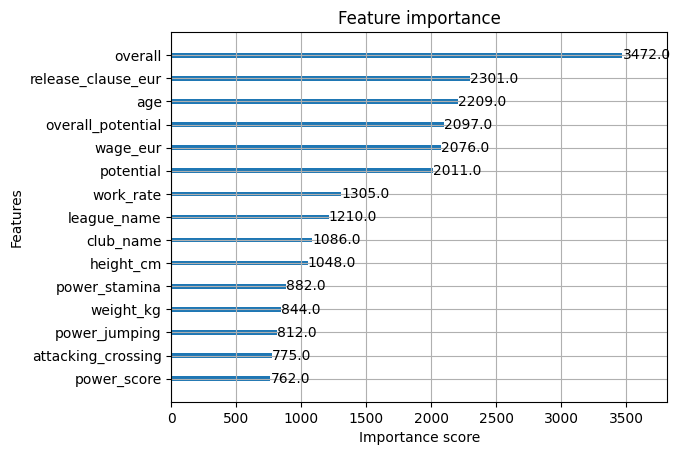

In [182]:
xgb.plot_importance(model, max_num_features=15, importance_type='weight')
plt.show()

In [183]:
# List of columns to keep
cols_to_keep = [
    "release_clause_eur", "overall_potential", 
    "wage_eur", "age", "league_name", 
    "club_name", "work_rate",
    "pace", "shooting",
    "passing", "dribbling", "defending",
    "physic"
]

# Filter the DataFrame to keep only the specified columns
X_train = X_train[cols_to_keep]
X_test = X_test[cols_to_keep]

In [184]:
# Create DMatrix for training and testing
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Define parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'seed': 42
}

# Train the model
num_round = 1000
model = xgb.train(params, dtrain, num_round)

# Evaluate the model
train_preds = model.predict(dtrain)
test_preds = model.predict(dtest)

train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 20181.465232982147
Test RMSE: 1344819.8301848972


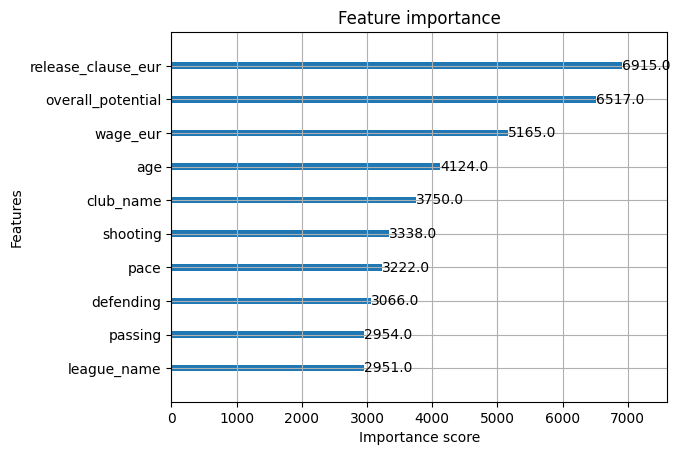

In [185]:
xgb.plot_importance(model, max_num_features=10, importance_type='weight')
plt.show()

In [186]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=100,
    random_state=42,
)

rf.fit(X_train, y_train)
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

# Evaluate the model
train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 314691.9571299871
Test RMSE: 607842.2537550649


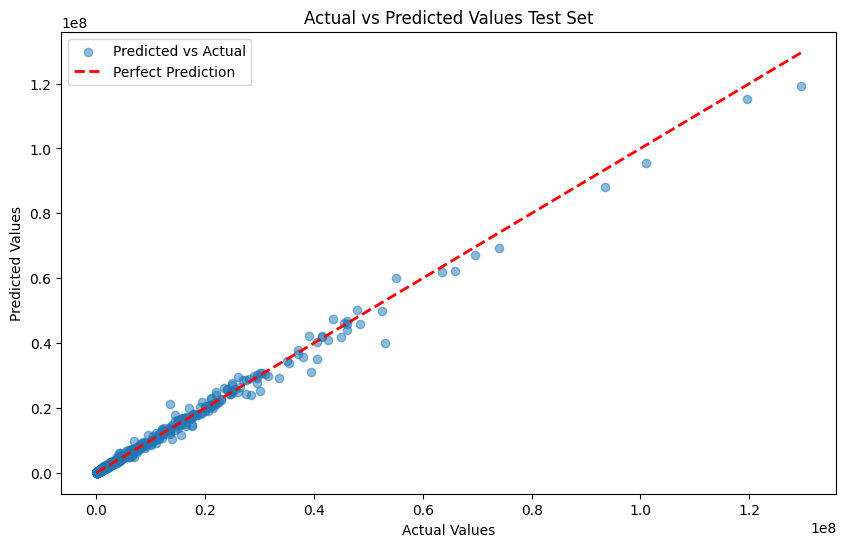

In [187]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_preds, alpha=0.5, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values Test Set")
plt.legend()
plt.show()

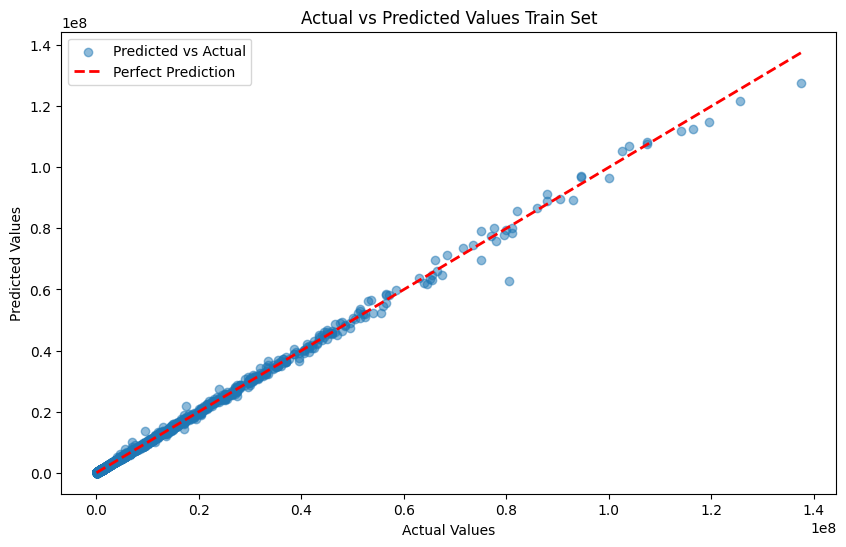

In [188]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_preds, alpha=0.5, label="Predicted vs Actual")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label="Perfect Prediction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values Train Set")
plt.legend()
plt.show()

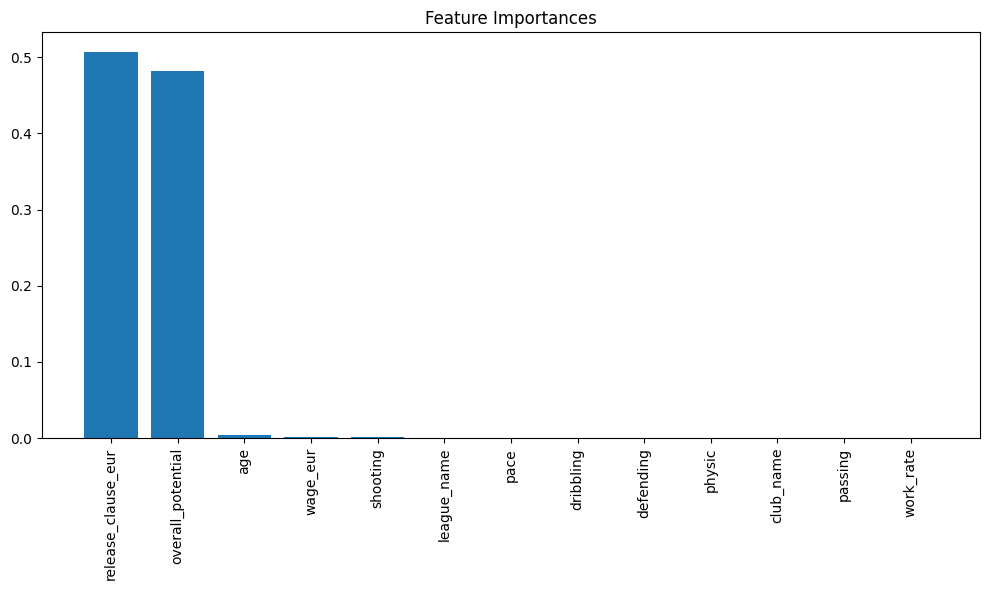

[5.07306656e-01 4.82339549e-01 3.94270138e-03 1.13769271e-03
 8.87090889e-04 7.91762943e-04 7.51555723e-04 5.80118859e-04
 5.71454366e-04 5.07790729e-04 4.92374834e-04 4.55529388e-04
 2.35722804e-04]


In [189]:
importances = rf.feature_importances_
features = X_train.columns

# Sort the feature importances in descending order
indices = importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()
print(importances[indices])

In [190]:
# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform regression
lm = LinearRegression()
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
lm.fit(X_train_scaled, y_train)
train_preds = lm.predict(X_train_scaled)
test_preds = lm.predict(X_test_scaled)

# Evaluate the model
train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 1479925.1600861992
Test RMSE: 1696682.534928213


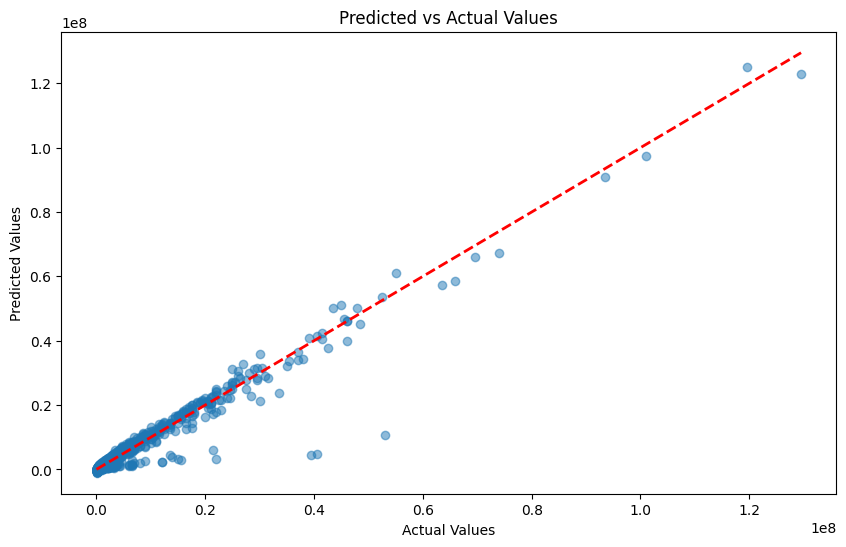

In [191]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

In [192]:
# Prepare LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameters for the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42
}

# Train the model
num_round = 1000
lgb_model = lgb.train(params, train_data, num_round, valid_sets=[train_data, test_data])

# Evaluate the model
train_preds = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
test_preds = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of data points in the train set: 10888, number of used features: 13
[LightGBM] [Info] Start training from score 2975128.122704
Train RMSE: 456518.2289275053
Test RMSE: 855033.8907422045


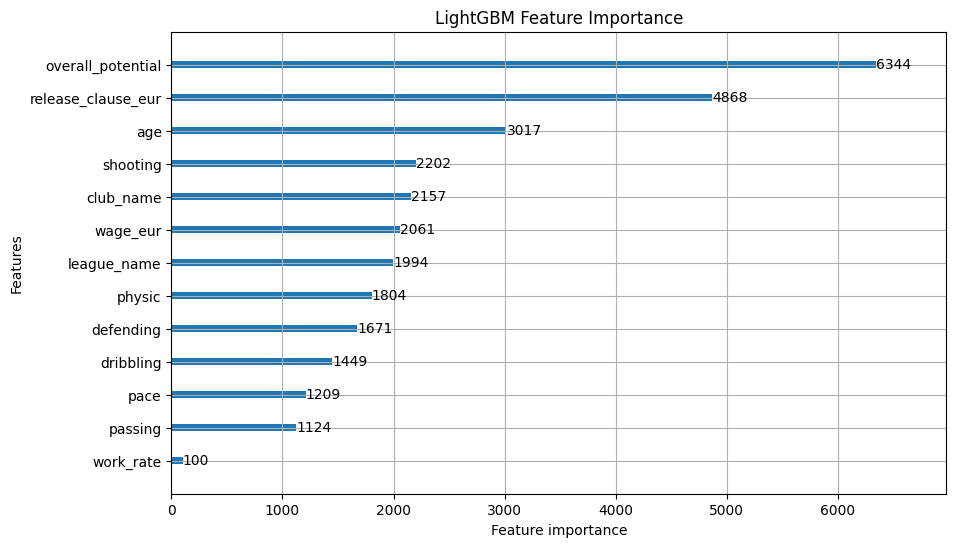

In [193]:
lgb.plot_importance(lgb_model, max_num_features=15, importance_type='split', figsize=(10, 6))
plt.title("LightGBM Feature Importance")
plt.show()